In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

# Data

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

from my_code import functions as f

In [6]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [7]:
n_aminoacids = len(string_list[0])

In [8]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [9]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [10]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float64) 
target_data = torch.tensor(Y, dtype=torch.float64).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float64)
target_validation = torch.tensor(Y_validation, dtype=torch.float64).view(-1, 1)

# Quantum node

In [11]:
import pennylane as qml

In [12]:
n_qubits = n_aminoacids
n_layers_block = 25
n_layers_embedding = 3
n_shots = 10000
# n_shots = None
dev = qml.device("default.qubit.torch", wires=n_qubits, shots=n_shots)


In [13]:
shape_weights_embedding = (n_layers_embedding, n_qubits, 2)
shape_weights_block_1 = (n_layers_block, n_qubits, 2)
shape_weights_block_2 = (n_layers_block, n_qubits//2, 2)

In [14]:
# size_weights = np.product(shape_weights_embedding) + np.product(shape_weights_block_1) + np.product(shape_weights_block_2)
size_weights = np.product(shape_weights_block_1) + np.product(shape_weights_block_2)

In [15]:
@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

    weights_block_1 = weights[:np.product(shape_weights_block_1)].reshape(shape_weights_block_1)
    weights_block_2 = weights[np.product(shape_weights_block_1):].reshape(shape_weights_block_2)

    # embedding layer
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # # embedding layer
    # for i in range(n_qubits):
    #     qml.RX(inputs[i], wires=i)

    #block
    for i in range(n_layers_block):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights_block_1[i,j,0], wires=j)
            qml.RZ(weights_block_1[i,j,1], wires=j)

        # ZZ rotation for neighboring qubits         
        for j in range(0,n_qubits,2): 
            qml.CNOT(wires=[j, (j+1)])

        # rotations for some qubits
        for j, w in enumerate(range(1, n_qubits, 4)): 
            qml.RY(weights_block_2[i,j,0], wires=w)
            qml.RZ(weights_block_2[i,j,1], wires=w)
            qml.RY(weights_block_2[i,j+1,0], wires=w+1)
            qml.RZ(weights_block_2[i,j+1,1], wires=w+1)
            qml.CNOT(wires=[w, (w+1)])

    # measurement
    return [qml.expval(qml.PauliZ(wires=1))]

In [16]:
qnode([1,2,3,4], np.zeros((size_weights,)))

[tensor(-0.2244)]

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

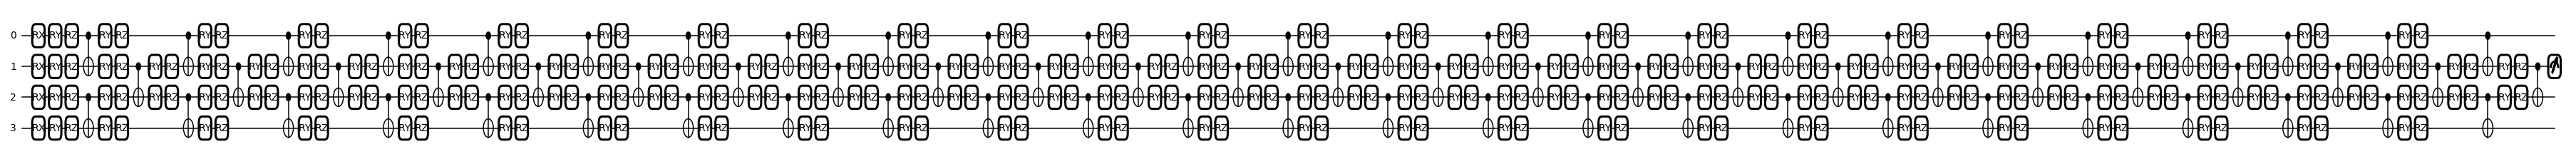

In [17]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(n_qubits)], np.zeros((size_weights,)))
fig.set_size_inches((50,3))

In [18]:
weight_shapes = {"weights": (size_weights,)}

In [19]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [20]:
class QNodeFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, qlayer):
        ctx.save_for_backward(input)
        ctx.qlayer = qlayer
        return qlayer(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        qlayer = ctx.qlayer
        epsilon = 0.1
        
        # Gradient w.r.t. input
        perturbation_input = (torch.rand_like(input) * 2 - 1)
        positive_input = input + perturbation_input * epsilon
        negative_input = input - perturbation_input * epsilon
        
        loss_positive = qlayer(positive_input).sum()
        loss_negative = qlayer(negative_input).sum()
        
        gradient_input = (loss_positive - loss_negative) / (2 * epsilon) * perturbation_input
        gradient_input *= grad_output  # Incorporate grad_output due to chain rule

        # Gradient w.r.t. qlayer's parameters
        gradients_weights = []
        for p in qlayer.parameters():
            perturbation_weight = (torch.rand_like(p) * 2 - 1) 

            p.data += perturbation_weight * epsilon  # Apply positive perturbation
            loss_positive = qlayer(input).sum()

            p.data -= 2*perturbation_weight * epsilon  # Apply negative perturbation
            loss_negative = qlayer(input).sum()

            gradient_weight = (loss_positive - loss_negative) / (2 * epsilon) * perturbation_weight 
            gradients_weights.append(gradient_weight * grad_output.sum())  # Weighting by grad_output

            p.data += perturbation_weight * epsilon  # Revert parameter back to original value

        # Update gradients for qlayer's parameters
        for p, grad in zip(qlayer.parameters(), gradients_weights):
            if p.grad is None:
                p.grad = grad.detach()
            else:
                p.grad += grad.detach()

        return gradient_input, None

# Wrapper around the custom autograd function
class CustomQLayer(torch.nn.Module):
    def __init__(self, qlayer):
        super(CustomQLayer, self).__init__()
        self.qlayer = qlayer

    def forward(self, x):
        return QNodeFunction.apply(x, self.qlayer)

# Hybrid model

In [ ]:
from my_code import pytorch_model as ptm
from my_code import nn as nn

In [21]:
input_dim = input_data.size(1)

In [22]:
n_pre_classical_layers = 4
layers_dim = np.linspace(n_qubits, input_dim, 4).astype(int)

In [23]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), nn.ReLU()]
layers += [nn.Linear(layers_dim[0], layers_dim[0])]
layers += [CustomQLayer(qlayer)]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]

In [24]:
# Create model and set data:
model = ptm.pytorch_model(layers)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [ ]:
# train the model
model.train()

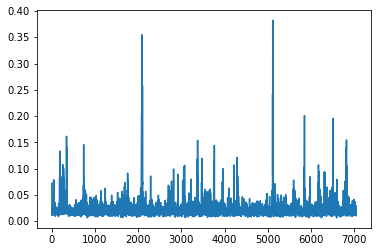

In [ ]:
# plot the losses of the trainig loop
model.plot_losses()

In [ ]:
#save model
name_notebook = "0731-small_hybrid_model_1qm_shots.ipynb"  

version = model.save_state_dict(name_notebook=name_notebook, initial_path=initial_path)

In [ ]:
# push changes to git
!cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 92667d0] data trained model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Notebooks/models/0731/0731-small_hybrid_model_Allqm_shots_0.pth
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 24 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 89.37 KiB | 6.88 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:raulconchello/peptide-QML.git
   06d0ee4..92667d0  main -> main


In [ ]:
#load model
model.load_state_dict(name_notebook=name_notebook, version=version, initial_path=initial_path)

In [ ]:
# print validation
model.print_validation()

i: 0, 	 target: 0.392, 	 output: -0.002, 	 loss: 0.193
i: 1, 	 target: -0.069, 	 output: 0.006, 	 loss: 0.003
i: 2, 	 target: -0.088, 	 output: -0.012, 	 loss: 0.010
i: 3, 	 target: -0.073, 	 output: 0.012, 	 loss: 0.012
i: 4, 	 target: 0.098, 	 output: -0.020, 	 loss: 0.007
i: 5, 	 target: 0.084, 	 output: 0.056, 	 loss: 0.008
i: 6, 	 target: 0.222, 	 output: -0.006, 	 loss: 0.050
i: 7, 	 target: 0.183, 	 output: 0.004, 	 loss: 0.021
i: 8, 	 target: 0.222, 	 output: -0.076, 	 loss: 0.058
i: 9, 	 target: -0.064, 	 output: -0.008, 	 loss: 0.010
i: 10, 	 target: 0.022, 	 output: 0.002, 	 loss: 0.000
i: 11, 	 target: -0.082, 	 output: 0.034, 	 loss: 0.009
i: 12, 	 target: -0.061, 	 output: -0.048, 	 loss: 0.004
i: 13, 	 target: 0.259, 	 output: 0.004, 	 loss: 0.074
i: 14, 	 target: -0.062, 	 output: -0.024, 	 loss: 0.013
i: 15, 	 target: 0.193, 	 output: -0.052, 	 loss: 0.044
i: 16, 	 target: 0.003, 	 output: -0.018, 	 loss: 0.000
i: 17, 	 target: -0.048, 	 output: 0.004, 	 loss: 0.005
i: